# RecoNet: Using Neural Networks to Reconstruct Phaseless Spectrograms
This notebook is a first attempt at implementing a reconstructing neural network for recovering audio sounds from magnitude spectrograms only. This is all in hopes of building generative models for audio sounds.

In [1]:
%matplotlib inline
import IPython.display


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gzip
import cPickle as pickle
import seaborn as sns
import random
import librosa
import sklearn

# Keras Imports
from keras.layers import Input, Dense, Lambda 
from keras.layers import Flatten, Reshape, Layer
from keras.layers import Conv2D, AveragePooling2D
from keras.layers import GaussianNoise
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical

from librosa.display import waveplot, specshow
sns.set(style='ticks')
# seaborn.set(style='white')

Using TensorFlow backend.


## Loading Data

In [2]:
# Loaded Spoken Digits Dataset
dbfile ='../SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)

df.head(n=3)    

File loaded as ../SpokenDigitDB.pkl.gz


,Class,Magnitude,PShift,Phase,SIndex,TStretch,Wave
0,0,"[[-22.0287, -39.3797, -19.2818, -19.0951, -51....",-1,"[[0.0, -3.14159, -3.14159, -3.14159, -3.14159,...",0,0.75,"[-0.00708008, -0.0124207, -0.011322, -0.014526..."
1,0,"[[-21.268, -32.4348, -30.0193, -20.2256, -21.6...",0,"[[0.0, 0.0, -3.14159, -3.14159, -3.14159, -3.1...",0,0.75,"[-0.0102234, -0.0121155, -0.0131531, -0.015747..."
2,0,"[[-21.2643, -27.9082, -28.497, -33.7005, -36.5...",1,"[[0.0, 0.0, 0.0, -3.14159, -3.14159, -3.14159,...",0,0.75,"[-0.0127563, -0.0126343, -0.0152283, -0.017486..."


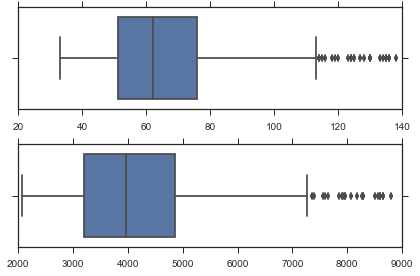

In [3]:
# Distribution of Audio Duration
a = [np.shape(x)[1] for x in df.Magnitude]
b = [np.shape(x) for x in df.Wave]

plt.figure(figsize=(6,4))
plt.subplot(211)
sns.boxplot(a)

plt.subplot(212)
sns.boxplot(b)
plt.tight_layout()

In [9]:
# y = df.Wave[404][:5120]
# s = librosa.stft(y,n_fft=128-1,hop_length=64)
# s.shape

(64, 80)

In [4]:
# Padding & Truncating
smax = 80    # Max number of frames in STFT
wmax = 5120  # Corresponding max number of samples
spad = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.min(a[:])*np.ones([a.shape[0],n - a.shape[1]])))
wpad = lambda a, n: a[:n] if a.shape[0] > n else np.append(a,np.zeros(n-a.shape[0]))

df.Magnitude = df.Magnitude.apply(spad,args=(smax,))  # MaxLen Truncation Voodoo :D
df.Wave      = df.Wave.apply(wpad,args=(wmax,))

print(np.unique([np.shape(x)[1] for x in df.Magnitude]))
print(np.unique([np.shape(x)[0] for x in df.Wave]))

[80]
[5120]


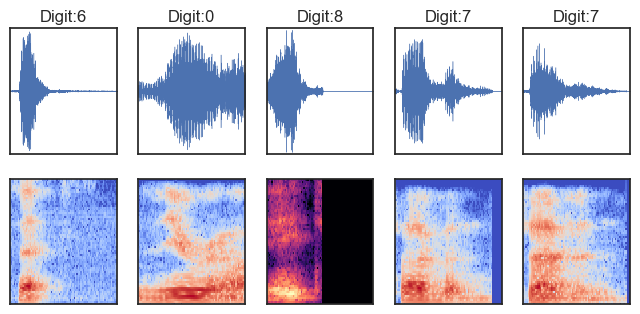

In [12]:
# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,sidx)    

sns.set(style='white')
for i,j in enumerate(sidx):
    if i<k:
        plt.subplot(3,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        plt.title('Digit:{1}'.format(j,df.Class[j]))
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().get_xaxis().set_visible(False)

    else:
        plt.subplot(3,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])

In [13]:
# Play back an example!
j = sidx[1]
IPython.display.Audio(data=df.Wave[j], rate=sr)

## Data Prep

In [14]:
# Prepare Data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_validation import train_test_split

# Randomize DataFrame
df = df.sample(frac=1,random_state=32)

# Train Scaler
x_data = df.Magnitude.values
normsc = np.hstack(x_data)
scaler = MinMaxScaler().fit(normsc.T)

# Transform Data using Scaler
x_data = [scaler.transform(arr.T).T for arr in df.Magnitude.values]
x_data = np.dstack(x_data).transpose(2,0,1)

# Add Singleton
x_data = x_data[...,None]         # Add singleton class
# y_data = to_categorical(df.Class.cat.codes)

# # Shuffle & Split
# x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,
#                               test_size=0.2, random_state=32)

# # Print Dimensions
# print 'Training Feature size:', x_train.shape
# print 'Training Target  size:', y_train.shape
# print ''
# print 'Testing  Feature size:', x_test.shape
# print 'Testing  Target  size:', y_test.shape

Training Feature size: (3607, 64, 80, 1)
Training Target  size: (3607, 10)

Testing  Feature size: (902, 64, 80, 1)
Testing  Target  size: (902, 10)


In [15]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

## ConvNet Model 

In [ ]:
# Parameters
chns, rows, cols = 1, 64, 84
img_size = (rows,cols,chns)

In [ ]:
# Model
x     = Input(shape=img_size)
conv1 = Conv2D(16,(3,5),name='C1',padding='same',activation='relu',strides=(2,2))(x)
conv2 = Conv2D(16,(3,3),name='C2',padding='same',activation='relu',strides=(2,2))(conv1)
conv3 = Conv2D(16,(3,3),name='C3',padding='same',activation='relu')(conv2)
avgpl = AveragePooling2D((4,4))(conv3)
flatn = Flatten()(avgpl)
y     = Dense(10,name='Classifier',activation='softmax')(flatn)


network = Model(x,y)
network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
network.summary()

## ToDo
# Use dilated convolutions?